In [1]:
import neurokit as nk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
def feature_calculator(d1):
    
    column=["Time","ECG"]
    d1.columns=column
    d1=d1.drop(0)
    d1=d1.reset_index(drop=True)
    
    x=int(d1.loc[0,'Time'][-2:-1])
    y=int(d1.loc[1,'Time'][-2:-1])
    di=y-x
    if di==1:
        sf=1000.0
    else:
        sf=500.0
    
    d1=d1.drop('Time',1)
    d1=d1.astype(float)
    
    
    bio = nk.ecg_preprocess(d1["ECG"], sampling_rate=sf)
    del(bio["ECG"]['Cardiac_Cycles'])
    d1['ECG_filtered']=bio['df']['ECG_Filtered']
    
    
    k=0
    if bio["ECG"]["P_Waves"][k]>bio["ECG"]["Q_Waves"][k]:
        bio["ECG"]["Q_Waves"]=np.delete(bio["ECG"]["Q_Waves"],0)
    if bio["ECG"]["Q_Waves"][k]>bio["ECG"]["R_Peaks"][k]:
        bio["ECG"]["R_Peaks"]=np.delete(bio["ECG"]["R_Peaks"],0)
    if bio["ECG"]["R_Peaks"][k]>bio["ECG"]["T_Waves"][k]:
        bio["ECG"]["T_Waves"]=np.delete(bio["ECG"]["T_Waves"],0)

    length=0
    for key in bio['ECG'].keys():
        if len(bio['ECG'][key])<length or not length:
            length=len(bio['ECG'][key])
    for key in bio['ECG'].keys():
        ar=np.arange(length,len(bio['ECG'][key]))
        bio['ECG'][key]=np.delete(bio['ECG'][key],ar)
        #print(key,len(bio['ECG'][key]))
        
        
    S_Waves=np.zeros((length,), dtype=int)
    for i in range(len(bio["ECG"]["R_Peaks"])):
        S_Waves[i]=d1.loc[bio['ECG']['P_Waves'][i]:bio['ECG']['T_Waves'][i],'ECG_filtered'].idxmin()
    bio['ECG']['S_Waves']=S_Waves
    #print(bio['ECG'])
    
    
    
    new_df=pd.DataFrame(bio['ECG'])
    new_df['QRS_interval']=di*(new_df['S_Waves']-new_df['Q_Waves'])
    new_df['PQ_interval']=di*(new_df['Q_Waves']-new_df['P_Waves'])
    new_df['QT_interval']=di*(new_df['T_Waves']-new_df['Q_Waves'])
    new_df['RR_interval']=di*(new_df['R_Peaks'].diff())
    for i in range(len(new_df.index)):
        new_df.loc[i,'P_amplitude']=d1.loc[new_df.loc[i,'P_Waves'],'ECG_filtered']
        new_df.loc[i,'R_amplitude']=d1.loc[new_df.loc[i,'R_Peaks'],'ECG_filtered']
        new_df.loc[i,'T_amplitude']=d1.loc[new_df.loc[i,'T_Waves'],'ECG_filtered']
    new_df = new_df.drop('P_Waves', 1) 
    new_df = new_df.drop('Q_Waves', 1)
    new_df = new_df.drop('T_Waves', 1)
    new_df = new_df.drop('S_Waves', 1)
    new_df = new_df.drop('R_Peaks', 1)
    #print(len(new_df.index))
    #print(new_df.head())
    return new_df
    
    

In [3]:
def file_reader():
    df=pd.DataFrame()
    for root, dirs, files in os.walk(r'data'):
        for file in files:
            d1=pd.read_csv(os.path.join(root, file))
            print("Reading file ",file)
            new_d=feature_calculator(pd.DataFrame(d1.iloc[:,0:2]))
            if int(file[9:-5])<=12:
                new_d['class']=1
            else:
                new_d['class']=0
               
            df=pd.concat([df,new_d])
            
    return df   

In [4]:
df=pd.DataFrame()
df=file_reader()
     

Reading file  samples (1).csv


C:\Users\GARG\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\GARG\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\GARG\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `

Reading file  samples (10).csv
Reading file  samples (11).csv
Reading file  samples (12).csv
Reading file  samples (13).csv
Reading file  samples (14).csv
Reading file  samples (15).csv
Reading file  samples (16).csv
Reading file  samples (17).csv
Reading file  samples (18).csv
Reading file  samples (19).csv
Reading file  samples (2).csv
Reading file  samples (20).csv
Reading file  samples (21).csv
Reading file  samples (22).csv
Reading file  samples (23).csv
Reading file  samples (24).csv
Reading file  samples (25).csv
Reading file  samples (26).csv
Reading file  samples (3).csv
Reading file  samples (4).csv
Reading file  samples (5).csv
Reading file  samples (6).csv
Reading file  samples (7).csv
Reading file  samples (8).csv
Reading file  samples (9).csv


In [5]:
print(len(df.index))
df=df.dropna()
print(len(df.index))
df.head()


2210
2184


,QRS_interval,PQ_interval,QT_interval,RR_interval,P_amplitude,R_amplitude,T_amplitude,class
1,57,94,288,742.0,0.029543,0.999226,0.126534,1
2,58,57,292,746.0,-0.052132,0.999169,0.131391,1
3,57,49,292,730.0,-0.096451,1.036440,0.130586,1
4,57,103,286,742.0,0.028471,1.012081,0.130808,1
5,56,45,290,754.0,-0.101115,0.994287,0.119405,1


In [6]:
df.corr()

,QRS_interval,PQ_interval,QT_interval,RR_interval,P_amplitude,R_amplitude,T_amplitude,class
QRS_interval,1.000000,-0.015112,0.275003,0.126350,-0.023560,0.080882,0.033371,-0.224261
PQ_interval,-0.015112,1.000000,0.287249,0.435740,-0.150959,-0.063386,0.093899,-0.123550
QT_interval,0.275003,0.287249,1.000000,0.600814,-0.224378,-0.102746,-0.049305,-0.037195
RR_interval,0.126350,0.435740,0.600814,1.000000,-0.079844,-0.119021,-0.010191,-0.171625
P_amplitude,-0.023560,-0.150959,-0.224378,-0.079844,1.000000,0.075516,0.007732,0.070257
R_amplitude,0.080882,-0.063386,-0.102746,-0.119021,0.075516,1.000000,0.539064,0.014014
T_amplitude,0.033371,0.093899,-0.049305,-0.010191,0.007732,0.539064,1.000000,0.052970
class,-0.224261,-0.123550,-0.037195,-0.171625,0.070257,0.014014,0.052970,1.000000


In [7]:
x=df.iloc[:,0:-1]
y=df.iloc[:,-1]

#### KNN Classifier

Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

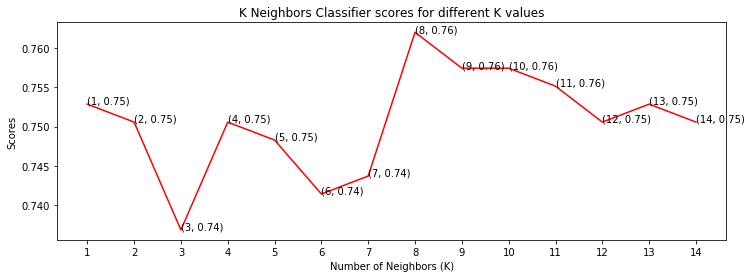

In [66]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
knn_scores = []
for k in range(1,15):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(x_train, y_train)
    knn_scores.append(knn_classifier.score(x_test, y_test))
figure= plt.subplots(figsize=(12, 4))
plt.plot([k for k in range(1, 15)], knn_scores, color = 'red')
for i in range(1,15):
    plt.text(i, knn_scores[i-1], (i, round(knn_scores[i-1],2)))

plt.xticks([i for i in range(1, 15)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')    

#### Decision Tree

Text(0.5, 1.0, 'Decision Tree Classifier scores for different number of maximum features')

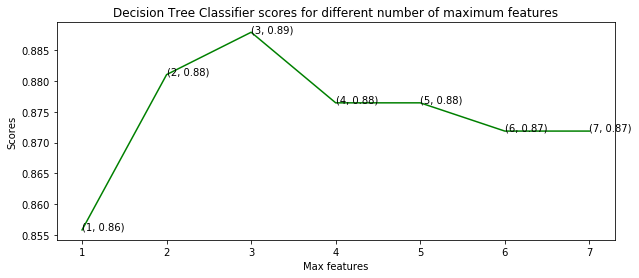

In [67]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
dt_scores = []
for i in range(1, len(x.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    dt_classifier.fit(x_train, y_train)
    dt_scores.append(dt_classifier.score(x_test, y_test))
figure= plt.subplots(figsize=(10, 4))
plt.plot([i for i in range(1, len(x.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(x.columns) + 1):
    plt.text(i, dt_scores[i-1], (i,round(dt_scores[i-1],2)))
plt.xticks([i for i in range(1, len(x.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')


## Random Forest

Text(0.5, 1.0, 'Random Forest Classifier scores for different number of estimators')

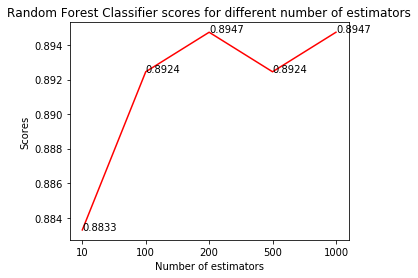

In [79]:
from matplotlib.cm import rainbow
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(x_train, y_train)
    rf_scores.append(rf_classifier.score(x_test, y_test))
colors = rainbow(np.linspace(0, 1, len(estimators)))
figure= plt.subplots(figsize=(5, 4))
plt.plot([i for i in range(len(estimators))], rf_scores, color = 'red')
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], round(rf_scores[i],4))
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators')

#### RAW ECG signal and Filtered ECG signal 

Text(0.5, 1.0, 'Raw ECG')

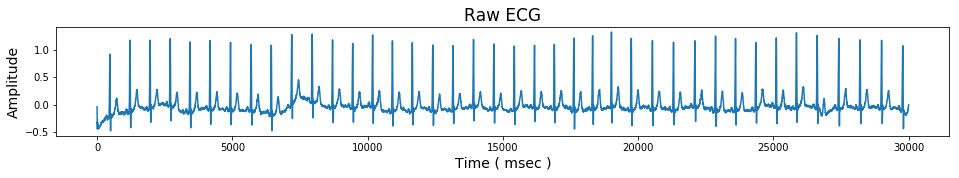

In [37]:
figure= plt.subplots(figsize=(16, 2))
d1['ECG'].iloc[0:30000].plot()
plt.xlabel("Time ( msec )",fontsize=14)
plt.ylabel("Amplitude",fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title("Raw ECG",fontsize=17)


Text(0.5, 1.0, 'Filtered ECG')

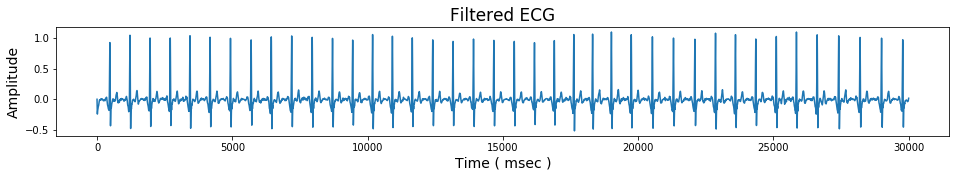

In [36]:
figure= plt.subplots(figsize=(16, 2))
ecg.iloc[0:30000].plot()
plt.xlabel("Time ( msec )",fontsize=14)
plt.ylabel("Amplitude",fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.title("Filtered ECG",fontsize=17)
